In [96]:
import pandas as pd
import numpy as np 
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df

df_train=readDataFromFile('../../homework/training_data_20210302.csv')
df_train = df_train.loc[df_train['TOOLG_ID']=='PK_DUVKrF']
# 觀察缺失值------------------------------------------
print(df_train.isnull().sum())
# 做数据切分------------------------------------------
print(df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1).describe())
# df_train_eh =pd.get_dummies(df_train.drop(['MOVE_QTY','MFG_DATE','AI'], axis=1),columns= [ 'TOOLG_ID'])
X_dropped = np.asarray(df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1))
Y_dropped = np.asarray(df_train['MOVE_QTY'])

X_train, X_val, y_train, y_val = train_test_split(X_dropped, Y_dropped, random_state=1) #Seed： 亂數種子，可以固定我們切割資料的結果random_state=777,
# dtrain = xgb.DMatrix(X_train,y_train)
# dval = xgb.DMatrix(X_val,y_val)

#調參------------------------------------------------------------
cv_params = {'n_estimators': [400, 500, 600, 700],'max_depth':[3,5,7],'min_child_weight':[1,3,5]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)

optimized_GBM.fit(X_train, y_train) 

test_score = optimized_GBM.score(X_val,y_val)

print('test得分:{0}'.format(test_score))
# evalute_result = optimized_GBM.grid_scores_
# print('每輪迭代執行結果:{0}'.format(evalute_result))
 
print('引數的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
print('cv_results_',optimized_GBM.cv_results_)



MFG_DATE       0
TOOLG_ID       0
WIP_QTY        0
NO_HOLD_QTY    0
MOVE_QTY       0
M              0
U              0
PT             0
UP_TIME        0
EQP_UTIL       0
TC             0
CS             0
AI             0
C_AI           0
dtype: int64
            WIP_QTY   NO_HOLD_QTY           M           U           PT  \
count    401.000000    401.000000  401.000000  401.000000   401.000000   
mean   15649.438903  14153.817955   30.710723    0.069952  2991.323249   
std     3268.166719   3199.797732    2.598290    0.058100    64.123117   
min     3163.000000   2805.000000    2.000000    0.033333  2821.530355   
25%    13475.000000  12024.000000   30.000000    0.063549  2949.116780   
50%    15328.000000  13833.000000   31.000000    0.065769  2988.247734   
75%    17406.000000  15948.000000   32.000000    0.068811  3027.918790   
max    31335.000000  29847.000000   32.000000    1.101804  3353.320665   

          UP_TIME    EQP_UTIL          TC          CS        C_AI  
count  401.000

In [82]:
optimized_GBM.estimator

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

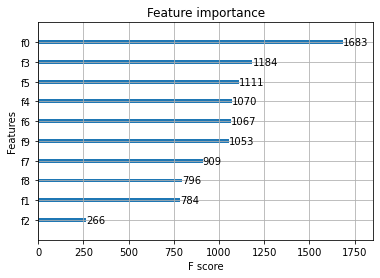

In [98]:
#===================================================
# # # 找出最重要的特徵 (值越大，特徵越重要)
from xgboost import plot_importance 
from matplotlib import pyplot 
# other_params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
# 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
# model = xgb.XGBRegressor(**other_params)

#引數的最佳取值：{'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 700}
model = optimized_GBM.estimator
# model.set_params(n_estimators=400) 
# model.set_params(min_child_weight=5) 
# model.set_params(max_depth=7) 
# model.fit(X_train, y_train)
plot_importance(model)#,max_num_features=10)
plt.show()

 

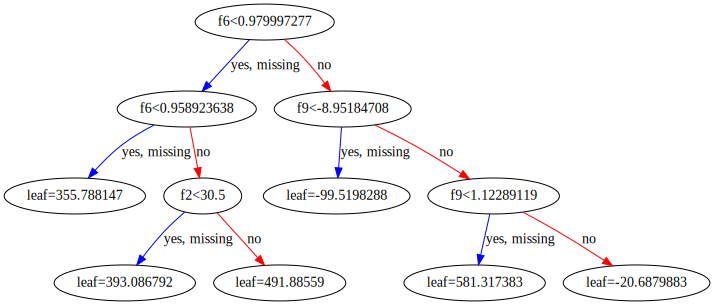

In [99]:
xgb.to_graphviz(model,num_trees=20)


In [103]:
cols=['M','U','PT','UP_TIME','EQP_UTIL','TC','CS','C_AI']
df_testing = df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1)
df_testing[cols]= df_testing[cols].mean()
df_testing =df_testing[0:1]
# max_wip = df_testing['NO_HOLD_QTY'].max()* .75
max_wip = np.percentile(df_testing['NO_HOLD_QTY'], 50) # return 50th percentile, e.g median.
tick = (df_testing['NO_HOLD_QTY'].max() - df_testing['NO_HOLD_QTY'].min()) /400
if max_wip <=0 :
    max_wip=100
if tick <10 :
    tick = 10
print(max_wip,tick)

df = pd.DataFrame(columns = df_testing.columns)

for i in range(1000):
    df_testing['NO_HOLD_QTY']=max_wip+ tick*i
    df = df.append(df_testing,ignore_index=True)
print(df.head())        
# TestModel(df,save_model)
#TestModelXG(df,save_modelxg)

17474.0 10
   WIP_QTY  NO_HOLD_QTY          M         U           PT   UP_TIME  EQP_UTIL  \
0  19000.0      17474.0  30.710723  0.069952  2991.323249  0.950456    0.9732   
1  19000.0      17484.0  30.710723  0.069952  2991.323249  0.950456    0.9732   
2  19000.0      17494.0  30.710723  0.069952  2991.323249  0.950456    0.9732   
3  19000.0      17504.0  30.710723  0.069952  2991.323249  0.950456    0.9732   
4  19000.0      17514.0  30.710723  0.069952  2991.323249  0.950456    0.9732   

         TC        CS      C_AI  
0  0.505878  0.297117  0.269249  
1  0.505878  0.297117  0.269249  
2  0.505878  0.297117  0.269249  
3  0.505878  0.297117  0.269249  
4  0.505878  0.297117  0.269249  


In [79]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

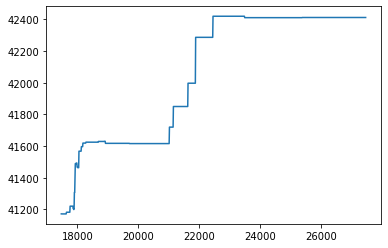

In [105]:
X_droppedtest = np.asarray(df)
# dtest = xgb.DMatrix(X_droppedtest)
# y_predict = model.predict(X_droppedtest)
y_predict = model.predict(X_droppedtest)
df['predict'] = y_predict # 預測WIP 數
plt.plot( df['NO_HOLD_QTY'] ,y_predict )
plt.show()
